In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv("0723_all_concat.csv", index_col = 0 )
data.head()

,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,kills,...,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,1,3,11,395.433780,byplayer,0,3,10,1,2,...,0,2403.4287,0,0.0,0,1492.000,0,2498.04880,8,4
1,0,1,0,0.000000,byzone,0,0,55,0,0,...,0,0.0000,0,0.0,0,893.000,0,239.93445,2,15
2,10,3,7,1284.158400,alive,3,3,2,4,8,...,0,4998.7627,0,0.0,0,1613.508,0,1773.35990,3,1
3,0,0,1,88.794075,byplayer,0,0,13,1,1,...,0,4143.0120,1,0.0,0,1295.000,0,826.75073,4,2
4,8,3,9,916.480100,byplayer,3,1,1,2,6,...,2,5006.8066,0,0.0,0,1456.000,0,1779.63440,3,5


In [3]:
data.columns

Index(['DBNOs', 'assists', 'boosts', 'damageDealt', 'deathType',
       'headshotKills', 'heals', 'killPlace', 'killStreaks', 'kills',
       'longestKill', 'mapName', 'matchType', 'name', 'playerId', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'timeSurvived', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       'winPlace'],
      dtype='object')

In [3]:
data.shape

(37065, 25)

In [4]:
data.columns

Index(['DBNOs', 'assists', 'boosts', 'damageDealt', 'deathType',
       'headshotKills', 'heals', 'killPlace', 'killStreaks', 'kills',
       'longestKill', 'mapName', 'matchType', 'name', 'playerId', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'timeSurvived', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       'winPlace'],
      dtype='object')

In [4]:
# 필요없는 변수 삭제
train = data.drop(columns = ["playerId","name"], axis = 1)

In [5]:
# 게임에서 튕긴 매치 제거
# 이동거리0 피해량0인 튕긴것같은 매치스텟

logout_index = train[(train["walkDistance"] == 0) & (train["damageDealt"] == 0)].index
train.drop(logout_index, inplace = True)

## Feature Engineering

1. 이동 거리 가중 평균

평균 속도로 각 방법 별로 이동 시간 예측 → 그 비율을 계산해서 가중치!

In [6]:
# 가중치 결과값 → 수영 0.00 / 걷기 0.78 / 자동차 0.22
train["movement_w_mean"] = 0*train["swimDistance"] + 0.78*train["walkDistance"] + 0.22*train["vehicleDestroys"]

2. 킬플레이스/윈플레이스

killPlace : 킬수에 따른 그 매치에서의 순위
winPlace : 몇번째로 죽었는가에 대한 순위

=> 얼마나 적게 죽이고 오래 살았나를 보면 "간디"메타와 "여포"메타를 구별지을 지표라 생각된다.

In [7]:
train["kill_over_winPlae"] = round(train["killPlace"]/train["winPlace"], 4)

3. 킬수/생존시간  

"여포"메타일수록 생존시간대비 킬수가 높을 것이다.


In [8]:
train["kill_over_timeSurvived"] = round(train["kills"]/train["timeSurvived"], 4)

4. Label encoding of categorical variable

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
columns = ["deathType", "mapName", "matchType"]

for col in columns :
    label_encoder = LabelEncoder()
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36593 entries, 0 to 37064
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DBNOs                   36593 non-null  int64  
 1   assists                 36593 non-null  int64  
 2   boosts                  36593 non-null  int64  
 3   damageDealt             36593 non-null  float64
 4   deathType               36593 non-null  int32  
 5   headshotKills           36593 non-null  int64  
 6   heals                   36593 non-null  int64  
 7   killPlace               36593 non-null  int64  
 8   killStreaks             36593 non-null  int64  
 9   kills                   36593 non-null  int64  
 10  longestKill             36593 non-null  float64
 11  mapName                 36593 non-null  int32  
 12  matchType               36593 non-null  int32  
 13  revives                 36593 non-null  int64  
 14  rideDistance            36593 non-null

In [12]:
# 0으로 나눠져 NaN되는 것을 입실론으로 처리
# 일단 드랍하고 진행
train["longestKill_over_movement_w_mean"] = round(train["longestKill"]/(train["movement_w_mean"]+ 1e-10), 4)

In [13]:
# 했는데 스케일링에서 infinity? 너무 큰 값 오류
train["timeSurvived_over_weaponsAcquired"] = round(train["timeSurvived"]/(train["weaponsAcquired"]+ 1e-10), 4)

## Normalization
### MinMaxScaler

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

train_scaled_df = pd.DataFrame(data = train_scaled, columns = train.columns )

In [16]:
train_scaled_df.shape

(36593, 28)

### StandardScaler

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

sta_train_scaled_df = pd.DataFrame(data = train_scaled, columns = train.columns )

# 군집분석

## GMM

In [17]:
from sklearn.mixture import GaussianMixture

In [19]:
# 군집갯수 : 2개

In [64]:
# 학습
# 세팅과 피팅
gmm = GaussianMixture(n_components = 3, random_state = 1234).fit(train)
# 아웃풋
gmm_cluster_labels = gmm.predict(train)

# 쌓기
train_scaled_df['GMM_cluster'] = gmm_cluster_labels

In [30]:
train_scaled_df

,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,killPlace,killStreaks,kills,...,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,movement_w_mean,kill_over_winPlae,kill_over_timeSurvived,GMM_cluster
0,-0.592942,1.254202,1.402065,-0.281955,0.155560,-0.571542,0.022482,-0.386525,-0.159618,-0.281742,...,-0.048602,0.591596,-0.292754,0.618270,0.346666,-0.402621,0.618249,-0.271552,-0.207444,0
1,-0.986999,-0.128844,-1.400860,-1.063487,1.674748,-0.571542,-0.921309,1.754458,-1.162177,-0.759135,...,-0.048602,-0.534804,-0.292754,-0.880514,-0.576994,0.896783,-0.880529,-0.040643,-0.361873,0
2,2.953566,1.254202,0.382819,1.474513,-1.363628,1.698723,0.022482,-0.767144,2.848059,1.150437,...,-0.048602,0.820087,-0.292754,0.137270,-0.423051,-0.757005,0.137252,-0.370510,0.232084,0
3,-0.986999,-0.820368,-1.146049,-0.887995,0.155560,-0.571542,-0.921309,-0.243792,-0.159618,-0.520438,...,-0.048602,0.221144,-0.292754,-0.491025,-0.269107,-0.638877,-0.491041,0.520113,-0.266840,1
4,2.165453,1.254202,0.892442,0.747837,0.155560,1.698723,-0.606712,-0.814721,0.842941,0.673044,...,-0.048602,0.523899,-0.292754,0.141435,-0.423051,-0.284494,0.141416,-0.726759,0.125172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36588,-0.592942,-0.820368,0.892442,-0.273322,-1.363628,0.185213,0.337078,-0.101060,-0.159618,-0.520438,...,-0.048602,1.274598,-0.292754,0.079190,0.192723,-0.757005,0.079171,2.400318,-0.302477,0
36589,-0.198886,-0.128844,-0.636426,-0.168394,0.155560,0.941968,-0.292115,-0.671989,0.842941,-0.043045,...,-0.048602,-0.019556,-0.292754,0.015718,0.038779,-0.757005,0.015700,0.025323,-0.053015,0
36590,-0.198886,-0.128844,0.637631,0.485131,-1.363628,-0.571542,2.853852,0.517446,-1.162177,-0.759135,...,-0.048602,1.131882,2.745463,-0.244317,0.346666,-0.757005,-0.244147,4.973230,-0.361873,1
36591,0.983284,-0.128844,1.656877,1.089722,-1.363628,2.455477,0.651675,-0.814721,0.842941,1.150437,...,-0.048602,1.232081,5.783680,0.352807,-0.269107,-0.757005,0.353162,-0.568426,0.160809,1


- 평가하기

-> 실루엣 분석을 동일하게 사용했습니다.

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score 

In [36]:
# 모든 개별 데이터 실루엣 계수 값 구하기
score_samples = silhouette_samples(train_scaled, sta_train_scaled_df["GMM_cluster"])
print("silhouette_samples() return 값의 shape", score_samples.shape)

silhouette_samples() return 값의 shape (36593,)


In [37]:
# train_scaled_df에 실루엣 계수 컬럼 추가
sta_train_scaled_df["silhouette_coeff"] = score_samples

In [38]:
# 모든 데이터의 평균 실루엣 계수 값 구하기
average_score = silhouette_score(train_scaled, train_scaled_df["GMM_cluster"])
print("개인 플레이 성향 Silhouette Analysis Score: {0:3f}".format(average_score))

KeyError: 'GMM_cluster'

### PCA 차원축소

In [19]:
from sklearn.decomposition import PCA

n_columns = 13
pca = PCA(n_components = 13)
pca.fit(train)

PCA(n_components=13)

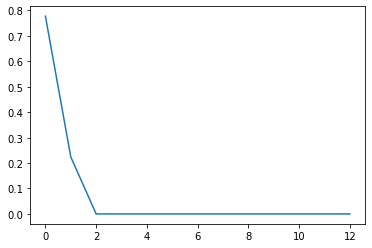

In [20]:
plt.plot(pca.explained_variance_ratio_)

In [21]:
n_columns = 2
pca = PCA(n_components = 2)
pca.fit(train)

np.sum(pca.explained_variance_ratio_)

0.9999999999999991

In [26]:
train_pca = pca.transform(train)

mMs = MinMaxScaler()
######################################################################################
train_pca_norm = mMs.fit_transform(train_pca)
train_pca_df = pd.DataFrame(data = train_pca_norm, columns = ['pc1', 'pc2'])

In [27]:
# 학습
# 세팅과 피팅
gmm = GaussianMixture(n_components = 4, random_state = 1234). fit(train_pca_df)
# 아웃풋
gmm_cluster_labels = gmm.predict(train_pca_df)

# 쌓기
train_scaled_df['GMM_cluster'] = gmm_cluster_labels

### tsne 차원축소

- Silhouette

In [29]:
# 모든 개별 데이터 실루엣 계수 값 구하기
score_samples = silhouette_samples(train_pca_norm, train_scaled_df["GMM_cluster"])
print("silhouette_samples() return 값의 shape", score_samples.shape)

silhouette_samples() return 값의 shape (36593,)


In [30]:
# train_scaled_df에 실루엣 계수 컬럼 추가
train_scaled_df["silhouette_coeff"] = score_samples

In [31]:
# 모든 데이터의 평균 실루엣 계수 값 구하기
average_score = silhouette_score(train_pca_norm, train_scaled_df["GMM_cluster"])
print("개인 플레이 성향 Silhouette Analysis Score: {0:3f}".format(average_score))

개인 플레이 성향 Silhouette Analysis Score: 0.986263
